In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from collections import Counter
import os
import torchvision.transforms.functional as TF

# Random Prototyping

In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: TF.rotate(x, -90)), transforms.Lambda(lambda x: TF.hflip(x)), transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, download=False, transform=transform)
test_set = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=False, transform=transform)

# Convert dataset to DataLoader (load all at once)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

# Extract train and test data
train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

# Flatten images from (N, 1, 28, 28) -> (N, 784)
train_data = train_data.view(train_data.shape[0], -1).to(device)  # (60000, 784)
test_data = test_data.view(test_data.shape[0], -1).to(device)  # (10000, 784)

train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

Using device: cpu


In [4]:
mapping_path = './data/EMNIST/raw/emnist-letters-mapping.txt'
mapping = pd.read_csv(mapping_path, delimiter=' ', header=None, index_col=0)
label_to_char = {index: chr(row[1]) for index, row in mapping.iterrows()}
train_labels_mapped = [label_to_char[label.item()] for label in train_labels]
test_labels_mapped = [label_to_char[label.item()] for label in test_labels]

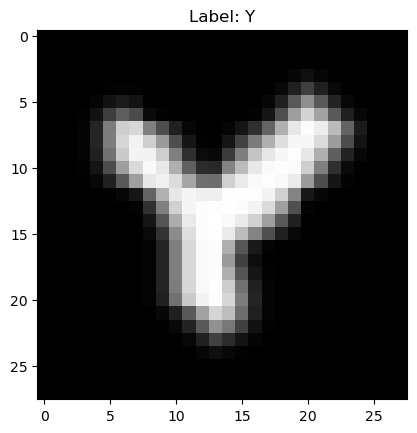

In [5]:
img, label = train_data[500], train_labels_mapped[500]  # Get first image & label
plt.imshow(img.view(28,28), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [3]:
num_subsets = np.array([75000, 50000, 10000, 5000, 1000])

In [4]:
def compute_accuracy(test_data, prototype_data, prototype_labels, k=1):
    # Compute full pairwise distance matrix in one go
    print("Computing full distance matrix...")
    distances = torch.cdist(test_data, prototype_data)  # Shape: (10000, 60000)

    # Get indices of k nearest neighbors
    k_indices = torch.topk(distances, k, largest=False).indices  # Shape: (10000, k)

    # Retrieve the k nearest labels
    k_labels = prototype_labels[k_indices]  # Shape: (10000, k)

    # Majority voting for prediction
    pred_labels = torch.mode(k_labels, dim=1).values  # Shape: (10000,)

    # Compute accuracy
    accuracy = (pred_labels == test_labels).float().mean().item()
    print(f'{k}-NN accuracy on full test set (no batching): {accuracy:.4f}')
    return accuracy

In [20]:
accuracy_dict = {}
for subset in num_subsets:
    accuracy_list = []
    for _ in range(30):
        random_indicies = torch.randperm(train_data.shape[0])[:subset]
        prototype_train_data = train_data[random_indicies]
        prototype_train_labels = train_labels[random_indicies]
        accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
        accuracy_list.append(accuracy)
    accuracy_dict[subset] = accuracy_list

Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8536
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8547
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8534
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8529
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8530
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8538
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8536
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8528
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8542
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8551
Computing full distance matrix...
1-NN accuracy on full test set (no batching): 0.8538
Computing full distance matrix...
1-NN accu

In [21]:
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.mean(), accuracy_df.std(ddof=1)

(100000    0.853282
 75000     0.845707
 50000     0.833377
 10000     0.766494
 5000      0.727639
 1000      0.599655
 dtype: float64,
 100000    0.000897
 75000     0.001687
 50000     0.002110
 10000     0.002243
 5000      0.003012
 1000      0.006118
 dtype: float64)

# K Means

## K Means

### Base Functions

In [7]:
# Perform K-Means clustering

def optimized_kmeans(X, k, num_iters=50, tol=1e-4, batch_size=100, device='cpu'):
    X = X.to(device)
    N, D = X.shape

    indices = torch.randperm(N)[:k]
    centroids = X[indices]

    for i in range(num_iters):
        distances = torch.empty((N, k), device=device)  # Preallocate memory
        
        for j in range(0, N, batch_size):
            batch_distances = torch.cdist(X[j:j+batch_size], centroids)
            distances[j:j+batch_size] = batch_distances
        
        cluster_assignments = torch.argmin(distances, dim=1)

        new_centroids = torch.zeros_like(centroids)
        counts = torch.zeros(k, device=device)

        for c in range(k):
            cluster_indices = (cluster_assignments == c).nonzero(as_tuple=True)[0]
            if cluster_indices.numel() > 0:
                new_centroids[c] = X[cluster_indices].mean(dim=0)
                counts[c] = cluster_indices.numel()
            else:
                new_centroids[c] = X[torch.randint(0, X.shape[0], (1,))].squeeze(0)  # Avoid empty clusters

        if torch.allclose(new_centroids, centroids, atol=tol):
            print(f'Converged at iteration {i}')
            break

        centroids = new_centroids

    return cluster_assignments, centroids


# Function to assign labels to centroids
def assign_labels(cluster_labels, y_true, k):
    """
    Assigns a label to each K-Means cluster using majority voting.
    
    Args:
    - cluster_labels (Tensor): Cluster assignments for each point
    - y_true (Tensor): True MNIST labels
    - k (int): Number of clusters

    Returns:
    - cluster_to_label (list): List where index `i` corresponds to cluster `i`'s assigned label
    """
    cluster_to_label = [-1] * k  # Initialize list with -1 for empty clusters

    for cluster in range(k):
        # Get all true labels for this cluster
        cluster_indices = (cluster_labels == cluster).nonzero(as_tuple=True)[0]
        true_labels = y_true[cluster_indices]

        # Find the most common label in this cluster
        if len(true_labels) > 0:
            most_common_label = Counter(true_labels.tolist()).most_common(1)[0][0]
            cluster_to_label[cluster] = most_common_label

    return cluster_to_label


### Centroids

In [8]:
for subset in num_subsets:
    if os.path.exists(f"emnist_centroids/mnist_kmeans_centroids_{subset}.pth"):
        continue
    else:
        cluster_labels, centroids = optimized_kmeans(train_data, subset)
        cluster_to_label = assign_labels(cluster_labels, train_labels, subset)
        torch.save(centroids, f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth")
        torch.save(cluster_to_label, f"emnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth")

: 

### Make Predictions

In [ ]:
accuracy_dict_kmeans = {}

for subset in num_subsets:
    prototype_train_data = torch.load(f"emnist_centroids/emnist_kmeans_centroids_{subset}.pth", weights_only=False)
    prototype_train_labels = torch.tensor(torch.load(f"emmnist_centroids/emnist_kmeans_cluster_labels_{subset}.pth", weights_only=False))
    accuracy = compute_accuracy(test_data, prototype_train_data, prototype_train_labels)
    accuracy_dict_kmeans[subset] = [accuracy]

In [ ]:
accuracy_df_kmeans = pd.DataFrame(accuracy_dict_kmeans)
accuracy_df_kmeans